In [24]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, \
    mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import trange

### Загрузка датасета

In [2]:
df = pd.read_csv(
    os.path.join(
        os.sep,
        os.path.abspath(os.curdir),
        'data',
        'Daily foreign exchange rates AustraliaUS BritishUS CanadianUS DutchUS .csv'),
    index_col=0)
ts = df['X0.90440445'].interpolate('linear').bfill()
ts.index = ts.index - 1

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from numpy import asarray

### Forecast

In [4]:
n_vars = 1
cols = list()

for i in range(1, 0, -1):
    cols.append(ts.shift(i))

for i in range(0, 1):
    cols.append(ts.shift(-i))

agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [5]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [6]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000, max_depth=10)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [148]:
size = int(len(list_for_forecast) * 0.9)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(
    list_for_forecast)]
dt_predictions = []
rf_predictions = []

history = [x for x in train]
for i in trange(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    dt_predictions.append(yhat)
    history.append(test[i])

history = [x for x in train ]
for i in trange(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    rf_predictions.append(yhat)
    history.append(test[i])

100%|██████████| 496/496 [47:23<00:00,  5.73s/it]


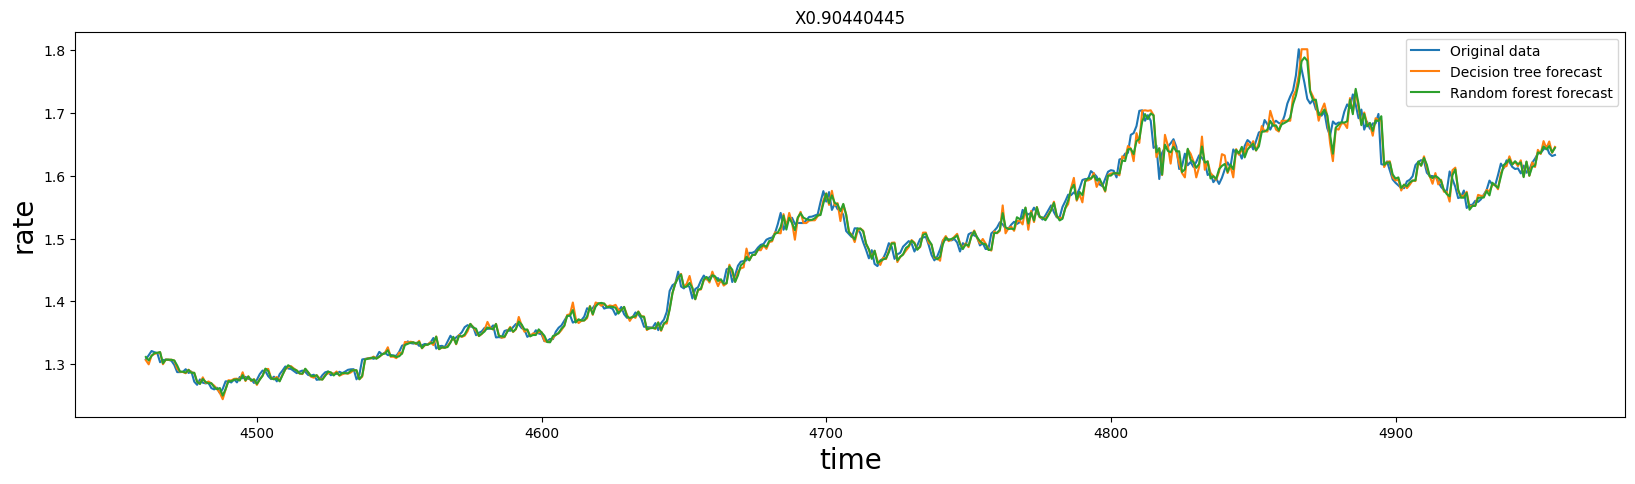

In [151]:
fig = plt.figure(figsize=(20, 5))
plt.plot(np.arange(size, len(list_for_forecast)), test[:, -1], label='Original data')
plt.plot(np.arange(size, len(list_for_forecast)), dt_predictions, label='Decision tree forecast')
plt.plot(np.arange(size, len(list_for_forecast)), rf_predictions, label='Random forest forecast')
plt.legend()
plt.title('X0.90440445')
plt.ylabel('rate', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

In [152]:
def calculate_smape(actual, predicted):
    return round(
        np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)))), 19)


print('Decision tree metrics')
print('RMSE:', np.sqrt(mean_squared_error(test[:, -1], dt_predictions)))
print('MAPE:', mean_absolute_percentage_error(test[:, -1], dt_predictions))
print('SMAPE:', calculate_smape(test[:, -1], dt_predictions))
print('MAE:', mean_absolute_error(test[:, -1], dt_predictions))
print('R2:', r2_score(test[:, -1], dt_predictions))

print('\n', 'Random forest metrics', sep='')
print('RMSE:', np.sqrt(mean_squared_error(test[:, -1], rf_predictions)))
print('MAPE:', mean_absolute_percentage_error(test[:, -1], rf_predictions))
print('SMAPE:', calculate_smape(test[:, -1], rf_predictions))
print('MAE:', mean_absolute_error(test[:, -1], rf_predictions))
print('R2:', r2_score(test[:, -1], rf_predictions))

Decision tree metrics
RMSE: 0.014530938194833393
MAPE: 0.00662509359458225
SMAPE: 0.003313404787959553
MAE: 0.010122596697764072
R2: 0.9890563300464923

Random forest metrics
RMSE: 0.012938483494383366
MAPE: 0.005879617871247846
SMAPE: 0.0029405722291809848
MAE: 0.00897662640076019
R2: 0.9913235428168896


### Детекция аномалий с помощью IsolatedForest

In [22]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.004)
model.fit(ts.to_numpy().reshape(-1, 1))

ts2 = pd.DataFrame(ts)
ts2['outliers'] = model.predict(ts.to_numpy().reshape(-1, 1))

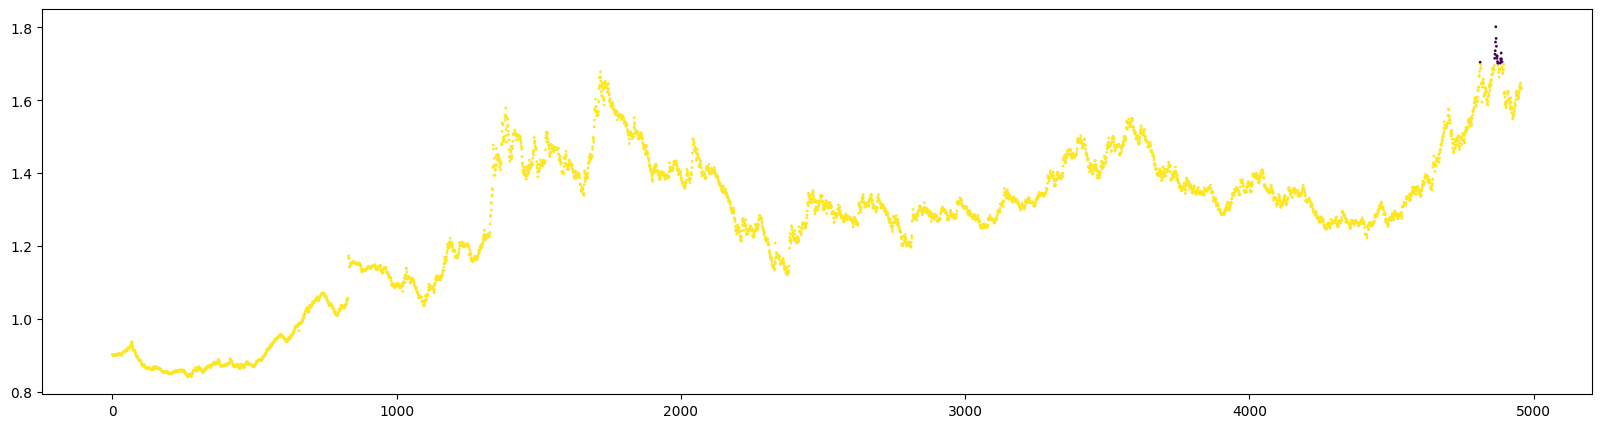

In [23]:
plt.figure(figsize=(20, 5))
plt.scatter(ts2.index, ts2['X0.90440445'], s=1, c=ts2['outliers'])
plt.show()